<a href="https://colab.research.google.com/github/ryzhikov114/portfolio/blob/main/diplom_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🙋‍♂️ Вступление

- Здравствуйте, добрый день!!! Дипломная работа ЯндексПрактики, на тему e-commerce магазина хозяйственных товаров. 

- В работе использованы библиотеки рandas, numpy, matplotlib, seaborn, sklearn. Анализ проведен на основе RFM, ABC, XYZ, DAU, MAU, WAU, ARPPU, кластеризация. Использован стат критерий Стьюдента.

**Бриф.**

Перед нами данные хозяйственного магазина e-commerce. 

**Задача:**

- Провести анализ данных, выявить дубликаты
- Агрегировать данные по товарам/покупателям
- Сегментировать покупателей на основе истории их покупок
- Сформулировать и проверить статистические гипотезы
- Выводы/рекомендации

# 📚 1. Импорт

In [ ]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import re
from scipy import stats as st
import pylab 
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# 🛒 2. Загрузка файла

https://drive.google.com/file/d/1ZrI6pGPTdGPgwEVHGpg92MgZ7MrNqDc9/view?usp=sharing

In [ ]:
!gdown 1ZrI6pGPTdGPgwEVHGpg92MgZ7MrNqDc9

Downloading...
From: https://drive.google.com/uc?id=1ZrI6pGPTdGPgwEVHGpg92MgZ7MrNqDc9
To: /content/ecommerce_dataset.csv
100% 1.04M/1.04M [00:00<00:00, 133MB/s]


In [ ]:
try:
  df = pd.read_csv('/datasets/ecommerce_dataset.csv')
except:
  df = pd.read_csv('/content/ecommerce_dataset.csv')

In [ ]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00000
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00000
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00000
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00000
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


- 5 стобцов
- 6737 строк
- пропуски отсуствуют

# 💡 3. Описание данных и предобработка

- **date** — дата заказа;
- **customer_id** — идентификатор покупателя;
- **order_id** — идентификатор заказа;
- **product** — наименование товара;
- **quantity** — количество товара в заказе;
- **price** — цена товара.

- В таблице встречаются строчные и заглавные названия, приведем все значнеия в нижний регистр.

In [ ]:
df = df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)

- добавим колонку с выручкой

In [ ]:
df['revenue'] = df['price'] * df['quantity']

## 3.1 Исправление типа

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [ ]:
df['dayweek'] = df['date'].dt.day_name()

In [ ]:
dayweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
           'Friday', 'Saturday', 'Sunday']
df['dayweek']= pd.Categorical(df['dayweek'], categories=dayweek, ordered=True)

In [ ]:
df['month'] = df['date'].dt.month_name()

#категории для сотировки месяцев
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)

In [ ]:
print(df['date'].min())
print(df['date'].max())

2018-10-01 00:00:00
2019-10-31 16:00:00


In [ ]:
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00000,142.00000,Monday,October
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.00000,194.00000,Monday,October
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00000,112.00000,Monday,October
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00000,179.00000,Monday,October
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00000,112.00000,Monday,October


- период данных 1 год и 31 день, с 2018 октября по 2019 октября, введем переменную которая выделит только год

In [ ]:
data_border = "2018-10-31"

## 3.2 Поиск дубликатов

In [ ]:
df.duplicated().sum()

0

- явных дубликатов нет

In [ ]:
df.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price']).sum()

1864

In [ ]:
df[df.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity'])].head()

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.00000,3299.00000,Tuesday,October
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.00000,3299.00000,Tuesday,October
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.00000,3299.00000,Tuesday,October
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.00000,3299.00000,Wednesday,October
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.00000,1409.00000,Thursday,October


- при проверке на дубликаты без колонки date, видим что один и тот же покупатель у него одинаковый номер заказа, стоимость, количество и выручка так же совпадают. Разное только время. Считаю что если бы клиент пришел и купил еще раз один и тот же товар, в таком же количестве, то именно номер заказа должен быть другой. Следовательно это дубликаты - удаляем.

In [ ]:
df = df.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])

- Поиск дубликатов среди '**customer_id**' и '**order_id**', выявил 29 дубликатов. Выяснилось что это ошибка, так как один заказ содержал одинковые поля, кроме поля customer_id. Получается что заказ один, а клиентов много, самый яркий пример где 4 разных клиента я вывел ниже. Принято решение удалить 

In [ ]:
df.groupby('order_id')['customer_id'].nunique().reset_index().query('customer_id > 1').head()

,order_id,customer_id
248,14872,2
516,68785,2
797,69283,2
817,69310,2
832,69345,2


In [ ]:
# заказ один а клиентов 4, в разное время
df.query('order_id == 72845')

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month
6504,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,муляж яблоко зеленый 9 см полиуретан,40,59.00000,2360.00000,Thursday,October
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,муляж яблоко зеленый 9 см полиуретан,40,59.00000,2360.00000,Thursday,October
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,муляж яблоко зеленый 9 см полиуретан,40,59.00000,2360.00000,Friday,October
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,муляж яблоко зеленый 9 см полиуретан,40,59.00000,2360.00000,Monday,October


In [ ]:
# список номеров заказов где были дубли
duplicate_order = list(df.groupby('order_id')['customer_id'].nunique().reset_index().query('customer_id > 1')['order_id'])
len(duplicate_order)

29

In [ ]:
# доп таблица очищеная от дубликатов
t = df.query('order_id == @duplicate_order').drop_duplicates(subset=['order_id', 'product'])
len(t)

32

In [ ]:
# удаляем все заказы из спасика дубликатов
df = df.query('order_id != @duplicate_order')
print(df.shape)
# возвращаем очищенную таблицу в главную
df = pd.concat([t, df])
print(df.shape)

(4807, 9)
(4839, 9)


- Преверив значения остался один заказ, но цена и название продукта разные. Будем считать что это разные заказы.

In [ ]:
df.groupby('order_id')['customer_id'].nunique().reset_index().query('customer_id > 1')

,order_id,customer_id
902,69485,2


In [ ]:
df.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,набор столовых приборов 24 предмета saint germ...,1,1087.00000,1087.00000,Thursday,December
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,набор столовых приборов 24 предмета farandole ...,1,1274.00000,1274.00000,Friday,December


## 3.3 Поиск аномалий

In [ ]:
df.describe()

,order_id,quantity,price,revenue
count,4839.00000,4839.00000,4839.00000,4839.00000
mean,48105.89585,2.81608,515.00248,850.69477
std,27363.40752,17.63910,945.53744,9841.41510
min,12624.00000,1.00000,9.00000,9.00000
25%,14772.50000,1.00000,90.00000,120.00000
50%,68854.00000,1.00000,150.00000,194.00000
75%,70810.50000,1.00000,488.00000,734.00000
max,73164.00000,1000.00000,14917.00000,675000.00000


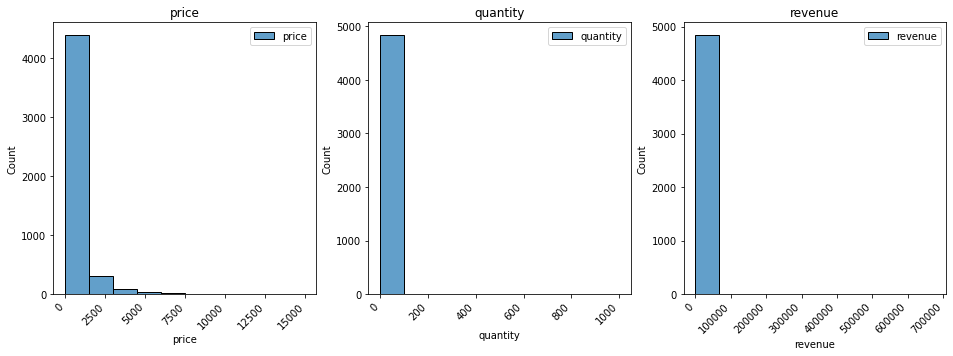

In [ ]:
cat_columns = df[['quantity', 'price', 'revenue']]


plt.figure(figsize=(16,5))
for i, column in enumerate(sorted(cat_columns)):
    plt.subplot(1,3,i+1)
    plt.title(column)
    sns.histplot(df, x=column, discrete=False, alpha=0.7, bins=10)
    plt.legend([column])
    plt.xticks(rotation=45,
      horizontalalignment='right',
      fontweight='light',
      fontsize='medium',)
plt.show()

- нужно посмотреть на quantity купленного товара в одном заказе, видим что максимальное значение довольно высокое, учитывая что 75% покупателей покупают 1 товар
- колонка price выглядит нормально, большинство товаров стоят до 2500 руб а самый дорогой 15000
- макимальное значение revenue так же выглядит как выброс, учитывая что 75% клиентов покупают на 600 руб

In [ ]:
t = (df.groupby('customer_id')
    .agg({
        'order_id': 'nunique',
        'quantity': 'sum',
        'revenue': 'sum',
        })
    .rename(columns={
        'order_id': 'unique_order_id',
        'quantity': 'quantity_product',
        'revenue': 'total_revenue'
        })
    .reset_index()
    )
t.head()

,customer_id,unique_order_id,quantity_product,total_revenue
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4,555.00000
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,442.00000
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,914.00000
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1649.00000
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,2324.00000


In [ ]:
print('количество заказов')
print(np.percentile(t['unique_order_id'], [100,99,2,1]))
print('========'*5)

print('количество товара в чеке')
print(np.percentile(t['quantity_product'], [100,99,98,97]))
print('========'*5)

print('общая выручка на клиента')
print(np.percentile(t['total_revenue'], [100,99,98,97]))
print('========'*5)

количество заказов
[126.   3.   1.   1.]
количество товара в чеке
[1000.    60.    34.6   30. ]
общая выручка на клиента
[675000.    8799.6   6731.    5463. ]


- выделим оптовых клиентов которые смазывают общую картину, разделим таблицы 

> ### 🤔 Что такое опт: 
- количество order_id на клиента маленькое
- quantity в заказе высокое
- revenue высокое

In [ ]:
order = np.percentile(t['unique_order_id'], [1])
quantity = np.percentile(t['quantity_product'], [99])
revenue = np.percentile(t['total_revenue'], [99])

In [ ]:
t.query('unique_order_id == @order and quantity_product >= @quantity and total_revenue >= @revenue')

,customer_id,unique_order_id,quantity_product,total_revenue
196,146cd9bf-a95c-4afb-915b-5f6684b17444,1,334,49432.00000
461,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,1000,675000.00000
862,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,300,15300.00000
1345,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,1,101,33680.00000


In [ ]:
list_opt = t.query('unique_order_id >= @order and quantity_product >= @quantity and total_revenue >= @revenue')['customer_id'].tolist()

### 3.3.1 Оптовая таблица

In [ ]:
opt_df = df.query('customer_id == @list_opt')
opt_df.head()

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.00000,674.00000,Monday,October
12,2018-10-01 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68485,чехол eurogold clean basic хлопок для досок 12...,1,187.00000,187.00000,Monday,October
20,2018-10-02 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68490,чехол для гладильной доски festival 137x60 см ...,1,1162.00000,1162.00000,Tuesday,October
21,2018-10-02 10:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68491,сумка-тележка 2-х колесная gimi argo синяя,1,1049.00000,1049.00000,Tuesday,October
42,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 3-х рядная деревянная 450 мм (пло...,15,49.00000,735.00000,Tuesday,October


In [ ]:
opt_df.groupby('customer_id')['revenue'].agg(['count', 'sum'])

,count,sum
customer_id,,
146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.00000
312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,675000.00000
498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4,41900.00000
4d93d3f6-8b24-403b-a74b-f5173e40d7db,45,57278.00000
5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,15300.00000
8fba3604-ef57-4b9f-b2fe-3402fa8825c8,6,33680.00000
c971fb21-d54c-4134-938f-16b62ee86d3b,143,159508.00000


In [ ]:
df = df.query('customer_id != @list_opt')
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month
512,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"сиденье в ванну раздвижное, белый, св5, ника",1,374.00000,374.00000,Sunday,October
1154,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,69283,сушилка для белья на батарею ника сб6-65 двухъ...,1,164.00000,164.00000,Monday,December
1177,2018-12-11 21:00:00,954172a5-634c-4a50-941d-9db6d15a7377,69310,"муляж груша желтый 9,5 см полиуретан",7,59.00000,413.00000,Tuesday,December
1196,2018-12-13 19:00:00,70d60304-4b3c-4f34-9430-1872ec6e6309,69345,сушилка для белья attribute прима 18 м синяя a...,1,974.00000,974.00000,Thursday,December
1237,2018-12-17 14:00:00,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,муляж желудь 2 шт,3,22.00000,66.00000,Monday,December


In [ ]:
df.describe()

,order_id,quantity,price,revenue
count,4638.00000,4638.00000,4638.00000,4638.00000
mean,47186.76434,2.40707,500.90319,665.03105
std,27583.43267,7.93120,937.98406,1446.22870
min,12624.00000,1.00000,9.00000,9.00000
25%,14765.00000,1.00000,90.00000,120.00000
50%,68834.00000,1.00000,150.00000,188.00000
75%,70890.25000,1.00000,472.00000,697.00000
max,73164.00000,200.00000,14917.00000,47385.00000


- после разделения, основная таблица стала с более реальными значениями

# 🧮 4. Агрегированние данных

## 4.1 Категории товаров

- Чтобы сделать категории товаров, возьмем первое слово из колонки product, создадим цикл где нам будет выводится слово, мы будем вручную для него писать категорию.

In [ ]:
#category_dict = defaultdict(list)

#category_list = list(dict.fromkeys(df['product'].sort_values().str.split().str.get(0)))

#полуавтоматическй цикл опередления слов в категории
#for i in range(len(category_list)):
#    print(category_list[i])
#    category = input()
#    category_dict[category].append(category_list[i])
#    print('======')

In [ ]:
# словарь категорий
category_dict = {'посуда': ['tepмокружка', 'бак', 'банка', 'бидон', 'блюдо', 'блюдце', 'бульонница', 'венчик', 'вилка', 'кастрюля', 'ковш', 'корыто', 'кружка', 'крышка', 'кувшин', 'кухонное', 'кухонные', 'ложка', 'лопатка', 'мерный', 'мини-сковорода', 'миска', 'нож', 'половник', 'противень', 'разделочная', 'рыбочистка', 'салатник', 'сахарница', 'скалка', 'сковорода', 'стакан', 'стеклянная', 'столовая', 'столовый', 'таз', 'тарелка', 'терка', 'термокружка', 'термос', 'термостакан', 'толкушка', 'фарфоровая', 'хлебница', 'чайная', 'чайник', 'чайный'], 'хозтовары': ['автоматическая', 'антижир', 'антинакипин', 'ароматизированное', 'бальзам', 'бельевые', 'бензин', 'ваза', 'ванна', 'вантуз', 'ведро', 'веник', 'веревка', 'весы', 'гипоаллергенный', 'гладильная', 'готовая', 'губка', 'дозатор', 'ерш', 'жидкое', 'запасная', 'защитная', 'защитный', 'иссоп', 'кипятильник', 'кисточка', 'ключница', 'кольца', 'комплект', 'концентрат', 'котовник', 'кофр', 'крепеж', 'масленка', 'молодило', 'мыло', 'мыло-скраб', 'мыльница', 'набор', 'насадка-моп', 'насадка-отжим', 'ножеточка', 'овощечистка', 'ополаскиватель', 'основание', 'отбеливатель', 'отделитель', 'отжим', 'паста', 'пена', 'перчатки', 'подарочный', 'подголовник', 'подставка', 'портулак', 'прищепки', 'пробка', 'пружина', 'пьезозажигалка', 'решетка', 'ролик', 'ручка', 'ручка-скоба', 'салфетница', 'сито', 'скребок', 'сменная', 'сменный', 'совок', 'средство', 'стиральный', 'стяжка', 'стяжки', 'тряпкодержатель', 'увлажняющая', 'универсальное', 'универсальный', 'фал', 'форма', 'холодная', 'чистящий', 'шнур', 'шпагат', 'шпингалет'], 'растения': ['агератум', 'адиантум', 'азалия', 'аквилегия', 'алиссум', 'алоэ', 'альбука', 'амариллис', 'анемона', 'антуриум', 'аптения', 'арбуз', 'аргирантерум', 'артемизия', 'аспарагус', 'астра', 'афеляндра', 'бадан', 'базилик', 'баклажан', 'бакопа', 'бальзамин', 'барвинок', 'бархатцы', 'бегония', 'буддлея', 'бузульник', 'валериана', 'вербейник', 'вербена', 'вероника', 'вигна', 'виола', 'газания', 'гайлардия', 'гардения', 'гвоздика', 'георгина', 'герань', 'гербера', 'гиацинт', 'гимнокалициум', 'гиностемма', 'гипсофила', 'глоксиния', 'годеция', 'горох', 'гортензия', 'девичий', 'декабрист', 'дендробиум', 'джункус', 'диффенбахия', 'драцена', 'душица', 'дыня', 'ель', 'завертка', 'замиокулькас', 'зверобой', 'земляника', 'змееголовник', 'зубная', 'импатиенс', 'кабачок', 'каланхое', 'калатея', 'календула', 'калибрахоа', 'калла', 'каллуна', 'калоцефалус', 'кампанула', 'капсикум', 'капуста', 'кипарисовик', 'клен', 'клубника', 'кодонанта', 'колеус', 'колокольчик', 'комнатное', 'кореопсис', 'кориандр', 'космея', 'кофе', 'крассула', 'крокусы', 'лаванда', 'лаватера', 'лавр', 'лантана', 'лапчатка', 'левкой', 'лен', 'лилейник', 'литопс', 'лобелия', 'лук', 'львиный', 'любисток', 'маттиола', 'мединилла', 'мелисса', 'мимоза', 'мирт', 'многолетнее', 'монарда', 'морковь', 'муррайя', 'мускари', 'мята', 'наматрасник', 'настурция', 'незабудка', 'нефролепис', 'нивянник', 'нолина', 'овсянница', 'огурец', 'однолетнее', 'осина', 'папоротник', 'патиссон', 'пахира', 'пеларгония', 'пеперомия', 'петрушка', 'петуния', 'пиретрум', 'платикодон', 'подсолнечник', 'примула', 'пряные', 'пуансетия', 'пуансеттия', 'радермахера', 'ранункулус', 'рассада', 'роза', 'розмарин', 'рудбекия', 'салат', 'сальвия', 'сантолина', 'седум', 'сельдерей', 'синнингия', 'скиммия', 'сметка', 'смолевка', 'соланум', 'солидаго', 'спатифиллум', 'суккулент', 'сциндапсус', 'табак', 'тагетис', 'тимьян', 'томат', 'томата', 'тыква', 'тюльпан', 'укроп', 'фаленопсис', 'фатсия', 'фиалка', 'физостегия', 'фикус', 'фиттония', 'флокс', 'фуксия', 'хамедорея', 'хлорофитум', 'хоста', 'хризантема', 'хризолидокарпус', 'цветок', 'цветущее', 'целозия', 'цикламен', 'цинерания', 'цинерария', 'циния', 'цинния', 'циперус', 'цитрофортунелла', 'чабер', 'шалфей', 'шеффлера', 'эвкалипт', 'энотера', 'эпипремнум', 'эхеверия', 'эхинацея', 'эхинокактус', 'эшшольция', 'юкка', 'ясколка'], 'инструмент/техника': ['вакуумный', 'измельчитель', 'измерительный', 'камнеломка', 'картофелемялка', 'кондиционер', 'котел', 'рассекатель', 'лестница', 'лестница-стремянка', 'линейка', 'мантоварка', 'мантоварка-пароварка', 'миксер', 'многофункциональный', 'овощеварка', 'окномойка', 'орехоколка', 'пресс', 'пылесос', 'сверло', 'сверло-фреза', 'соковарка', 'соковыжималка', 'сотейник', 'стремянка', 'стремянка-табурет', 'стремянки', 'термометр', 'тортница', 'утюг', 'фен', 'швабра', 'шило', 'шприц', 'штанга', 'штангенциркуль', 'щетка', 'щетка-сметка', 'щетка-утюжок', 'электроштопор'], 'хранение': ['вешалка', 'вешалка-перекладина', 'вешалка-плечики', 'вешалка-стойка', 'вешалка-сушилка', 'вешалки', 'вкладыши', 'держатель', 'емкость', 'жестяная', 'контейнер', 'корзина', 'корзинка', 'короб', 'коробка', 'крючок', 'лоток', 'мешок', 'мусорный', 'петля', 'петля-стрела', 'плечики', 'полка', 'полки', 'стеллаж', 'сумка', 'сумка-тележка', 'сушилка', 'тележка', 'уголок', 'урна', 'урна-пепельница', 'фиксатор-шар', 'чехол', 'этажерка', 'ящик'], 'текстиль': ['двуспальное', 'ковер', 'коврик', 'махровое', 'махровый', 'наволочка', 'наматрацник', 'наматрицник-чехол', 'нетканые', 'одеяло', 'плед', 'подкладка', 'пододеяльник', 'подрукавник', 'подушка', 'покрывало', 'покрытие', 'полотенце', 'простынь', 'простыня', 'рукав', 'салфетка', 'сервировочная', 'скатерть', 'ткань', 'тряпка', 'халат', 'штора'], 'сад/декор': ['декоративная', 'доска', 'искусственная', 'искусственный', 'карниз', 'комод', 'модульная', 'муляж', 'насадка', 'настенная', 'настольная', 'новогоднее', 'обувница-', 'подвесное', 'просеиватель', 'светильник', 'сетка', 'сиденье', 'складная', 'складной', 'фоторамка'], }

In [ ]:
# опредление категории по словарю
def category_func(name):
  for key, value in category_dict.items():
    for word in value: #ищем слова в значении словаря
      if name.find(word) > -1: #если слово найдено(True), возвращает ключ словаря
        return key
  return 'no_category'

In [ ]:
df['product_category'] = df['product'].str.replace('ё','е').apply(category_func)

In [ ]:
df.groupby('product_category')['revenue'].agg(['count', 'sum']).reset_index().sort_values(by='sum')

,product_category,count,sum
3,сад/декор,155,83707.00000
0,инструмент/техника,119,170446.00000
1,посуда,407,228513.00000
4,текстиль,219,269208.00000
5,хозтовары,381,455093.00000
6,хранение,510,911231.00000
2,растения,2847,966216.00000


> Мы получили 7 категорий, которые сильно отличаются друг от друга по количеству позиций товара, а также выручкой. Стоит объеденить категории чтобы осталось 4, так как это учебный проект. В жизни я бы поделил их на еще большее количество категорий, для более детального изучения.
- растения
- хранение
- хозтовары (добавим инструмент/техника)
- интерьер (посуда + текстиль + сад/декор)

In [ ]:
df['product_category'] = (df['product_category']
                          .apply(lambda x: 'хозтовары' if x == 'инструмент/техника' else x))
df['product_category'] = (df['product_category']
                          .apply(lambda x: 'интерьер' if x == 'посуда' 
                                 or x == 'текстиль' 
                                 or x == 'сад/декор' else x))

In [ ]:
df.groupby('product_category')['revenue'].agg(['nunique', 'sum']).reset_index().sort_values(by='sum')

,product_category,nunique,sum
0,интерьер,293,581428.00000
2,хозтовары,214,625539.00000
3,хранение,193,911231.00000
1,растения,346,966216.00000


## 4.2 Профили клиентов

- создание профиля юзера по id, дате первого заказа, выручке, сколько дней прошло с последней покупки, количество заказов



In [ ]:
# последний день покупки
df = df.merge(df.groupby('customer_id')['date'].last().reset_index()
        .rename(columns={'date': 'last_purchase'}), 
        how='left', on='customer_id')

In [ ]:
# функция для создания пользовательских профилей

def get_profiles(df, date_start, date_constant):

  profiles = (
    df.query('date >= @date_start')
    .sort_values(by=['customer_id', 'date'])
    .groupby('customer_id')
    .agg({
        'date': 'first',
        'last_purchase': 'last',
        'revenue': 'sum',
        'order_id': 'nunique'
        })
    .rename(columns={
        'date': 'first_purchase',
        'revenue': 'monetary',
        'order_id': 'frequency'
        })
    .reset_index()
  )

# добавляем последний день покупки
  profiles['recency'] = (date_constant - pd.to_datetime(profiles['last_purchase'])).dt.days
  profiles['first_purchase'] = profiles['first_purchase'].dt.date
  profiles['last_purchase'] = profiles['last_purchase'].dt.date

  return profiles

In [ ]:
df['date'].max()

Timestamp('2019-10-31 14:00:00')

In [ ]:
profiles = get_profiles(df, pd.to_datetime('2019-04-01'), df['date'].max())

In [ ]:
profiles.head()

,customer_id,first_purchase,last_purchase,monetary,frequency,recency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16,2019-10-16,555.00000,1,15
1,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14,2019-10-14,914.00000,1,16
2,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29,2019-09-29,2324.00000,1,31
3,00e59a12-06d5-47fc-9a33-bfc53aca1e9f,2019-07-13,2019-07-13,1798.00000,1,109
4,0114e87e-78e2-49bf-9c8c-bbddd7191a3f,2019-10-15,2019-10-15,974.00000,1,15


# 🔎 5. Анализ данных

In [ ]:
# Функции графиков

def univariate_multi_plot(df=df, x=None, xlabel=None, rotation=None):
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    sns.countplot(data=df, x=x, ax=ax[0], order=df[x].value_counts(ascending=True).index, alpha=0.7)
    df[x].value_counts(ascending=True).plot(kind="pie", autopct="%1.1f%%", ax=ax[1], wedgeprops={'alpha':0.7})
    sns.despine(bottom=True, left=True)
    ax[0].set_xlabel(xlabel=xlabel, size=12)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='center')
    ax[0].set_ylabel(ylabel="")
    ax[1].set_ylabel(ylabel="")
    fig.text(0.5, 1, f'Количество клиентов ({xlabel})', size=16, ha="center", va="center")
    plt.show()

## 5.1 Количество покупок по дням/месяцам

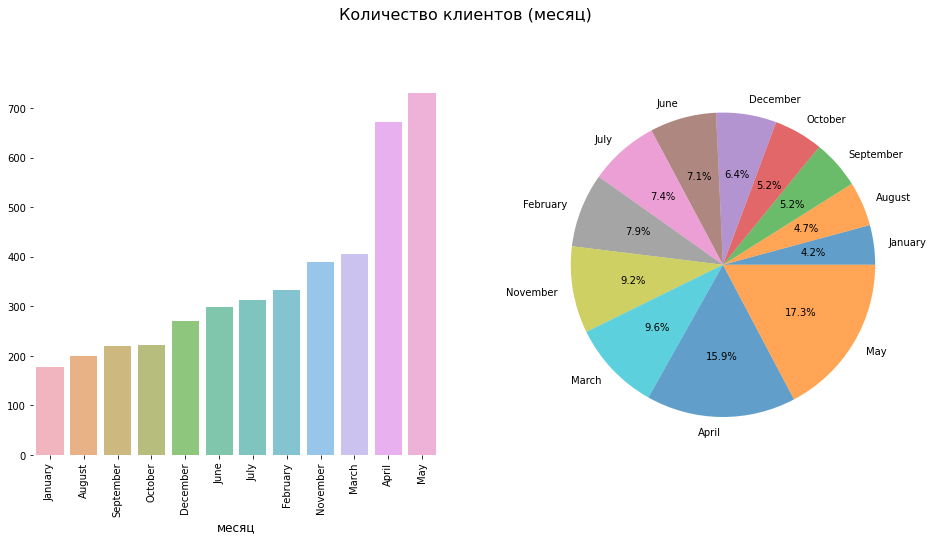

In [ ]:
univariate_multi_plot(df=df.query('date > @data_border'), x="month", xlabel="месяц", rotation=90)

- Больше всего клиентов в апреле и мае, возможно это связано с сезоном, так как в нашем магазине широкий ассортимент растений.
- Январь самый маленький поток клиентов

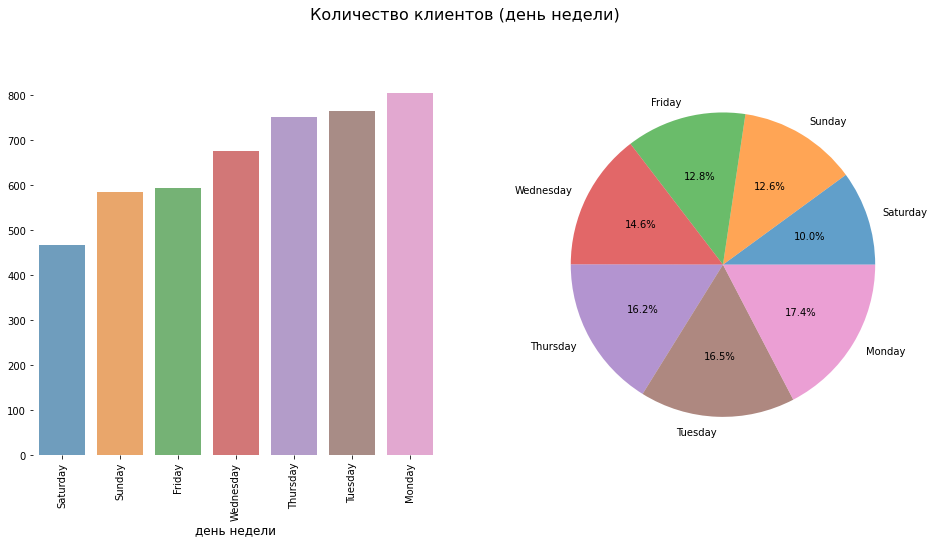

In [ ]:
univariate_multi_plot(df=df, x="dayweek", xlabel="день недели", rotation=90)

- В наш магазин ходят в рабочие дни особенно в понедельник, в выходные и пятницу ходят меньше.

## 5.2 DAW WAU MAU

In [ ]:
q = pd.DataFrame()
q['customer_id'] = df['customer_id']
q['session_year'] = df['date'].dt.year
q['session_month'] = df['date'].dt.month
q['session_week'] = df['date'].dt.isocalendar().week
q['session_date'] = df['date'].dt.date

In [ ]:
q.head()

,customer_id,session_year,session_month,session_week,session_date
0,0b5ce2c7-acef-4a9a-b821-61a44ed05557,2018,10,43,2018-10-28
1,2f955596-4b13-432e-93f3-6433395aafe6,2018,12,50,2018-12-10
2,954172a5-634c-4a50-941d-9db6d15a7377,2018,12,50,2018-12-11
3,70d60304-4b3c-4f34-9430-1872ec6e6309,2018,12,50,2018-12-13
4,4ea06f66-0876-4dec-8d14-ea994ffe435f,2018,12,51,2018-12-17


In [ ]:
dau_total = (
    q.groupby('session_date')
    .agg({'customer_id': 'nunique'})
    .mean()
)
wau_total = (
    q.groupby(['session_year', 'session_week'])
    .agg({'customer_id': 'nunique'})
    .mean()
)
mau_total = (
    q.groupby(['session_year', 'session_month'])
    .agg({'customer_id': 'nunique'})
    .mean()
)

print('Активных ежедневных пользователей', int(dau_total), '"DAU"')
print('='*20)
print('Активных недельных пользователей', int(wau_total), '"WAU"')
print('='*20)
print('Активных месячных пользователей', int(mau_total), '"MAU"') 
print('='*20)

Активных ежедневных пользователей 6 "DAU"
Активных недельных пользователей 43 "WAU"
Активных месячных пользователей 189 "MAU"


## 5.3 ARPPU

In [ ]:
print(df['date'].min())
print(df['date'].max())

2018-10-01 00:00:00
2019-10-31 14:00:00


In [ ]:
year_arpu = (
    (df.query('date > @data_border').groupby('month')['revenue'].sum() / 
     df.query('date > @data_border').groupby('month')['customer_id'].count())
    .reset_index()
    .rename(columns={0:'arppu'})
    )

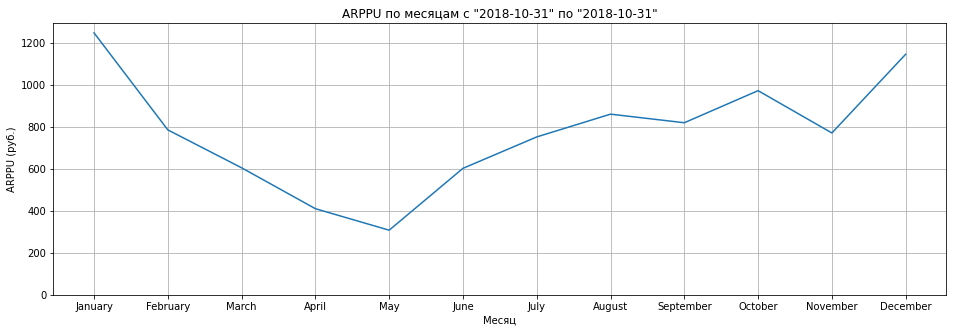

In [ ]:
plt.figure(figsize = (16, 5))
sns.lineplot(data=year_arpu, x='month', y="arppu")
plt.title('ARPPU по месяцам с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='Месяц')
plt.ylabel(ylabel='ARPPU (руб.)')
plt.grid()
plt.ylim(0)
plt.show()

In [ ]:
year_arpu.set_index('month').T

month,January,February,March,April,May,June,July,August,September,October,November,December
arppu,1247.89888,785.69369,605.02217,410.27083,307.80985,602.48495,752.10863,860.61000,819.74429,972.55204,770.99231,1146.02583


- высокие средние чеки в январе и декабре, именно те месяцы когда у нас мало клиентов, и низкие средние чеки в апреле и мае, тогда когда у нас много клиентов. Выглидит логично, зимой рассаду не покупают.

## 5.4 RFM

https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17

> recency frequency monetary  
- r (как давно что-то покупал? Чем более недавно, тем лучше) 1-4  
- f (как часто покупал ранее? Чем чаще, тем лучше) 1-4  
- m (как много денег потратил на нас? Чем больше, тем лучше) 1-4  

In [ ]:
profiles['r'] = 5 - (pd.qcut(profiles['recency'],q=4,labels=False) + 1)

- Клиентов с 1 заказом слишком много, мы не можем разбить их на равные группы. Сделаем везде где 1 заказ = 1, 2 заказа = 2, 3 заказа = 3, >4 заказов = 4

In [ ]:
def frequency (x):
  if x == 1:
    return 1
  if x == 2:
    return 2
  if x == 3:
    return 3
  return 4

In [ ]:
profiles['f'] = profiles['frequency'].apply(frequency)

In [ ]:
profiles['m'] = pd.qcut(profiles['monetary'],q=4,labels=False) + 1

In [ ]:
profiles['rfm_score'] = profiles['r'] + profiles['f'] + profiles['m']

In [ ]:
def rfm_level(df):
    if df['rfm_score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['rfm_score'] >= 8) and (df['rfm_score'] < 9)):
        return 'Champions'
    elif ((df['rfm_score'] >= 7) and (df['rfm_score'] < 8)):
        return 'Loyal'
    elif ((df['rfm_score'] >= 6) and (df['rfm_score'] < 7)):
        return 'Potential'
    elif ((df['rfm_score'] >= 5) and (df['rfm_score'] < 6)):
        return 'Promising'
    elif ((df['rfm_score'] >= 4) and (df['rfm_score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [ ]:
profiles['segment'] = profiles.apply(rfm_level,axis=1)

In [ ]:
profiles.sort_values(by='rfm_score', ascending=False).head()

,customer_id,first_purchase,last_purchase,monetary,frequency,recency,r,f,m,rfm_score,segment
573,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,2019-10-02,2019-10-31,21361.00000,17,0,4,4,4,12,Can't Loose Them
63,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,2019-08-21,2019-10-08,1538.00000,3,23,4,3,4,11,Can't Loose Them
1099,e8204583-4d55-4724-ad3f-049c7db43bdd,2019-07-23,2019-09-06,3102.00000,3,54,4,3,4,11,Can't Loose Them
913,bea7a833-2074-42db-bc49-4457abd3c930,2019-05-14,2019-06-17,4409.00000,4,135,2,4,4,10,Can't Loose Them
990,d02429ab-22e0-4ff2-9465-3082befde444,2019-08-24,2019-08-25,3261.00000,3,67,3,3,4,10,Can't Loose Them


- Получился немного некорректный rfm анализ из за того что в наш магазин приходят и не возвращаются... Это повод задуматься, прежде чем что то делать с клиентами и пытаться их вернуть, нужно посмотреть внутри магазина там явно что то не так. Например в апреле и мае все хорошо потому что сезон посадки, нужно придумывать что делать в остальные месяцы.

In [ ]:
df = df.merge(profiles[['customer_id', 'rfm_score', 'segment']], how='left', on='customer_id')

In [ ]:
df['rfm_score'] = df['rfm_score'].fillna(0)
df['segment'] = df['segment'].fillna('no_rfm')

In [ ]:
df.head(1)

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month,product_category,last_purchase,rfm_score,segment
0,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"сиденье в ванну раздвижное, белый, св5, ника",1,374.00000,374.00000,Sunday,October,интерьер,2018-10-28 22:00:00,0.00000,no_rfm


In [ ]:
rfm_level_agg = df.query('segment != "no_rfm"').groupby('segment').agg({
    'customer_id': 'nunique',
    'order_id': 'nunique',
    'revenue': 'mean'
}).reset_index()
rfm_level_agg

,segment,customer_id,order_id,revenue
0,Can't Loose Them,94,158,1264.60317
1,Champions,156,179,1036.78095
2,Loyal,228,255,602.03436
3,Needs Attention,128,130,230.93529
4,Potential,309,321,416.80890
5,Promising,234,244,233.67754
6,Require Activation,76,79,129.58537


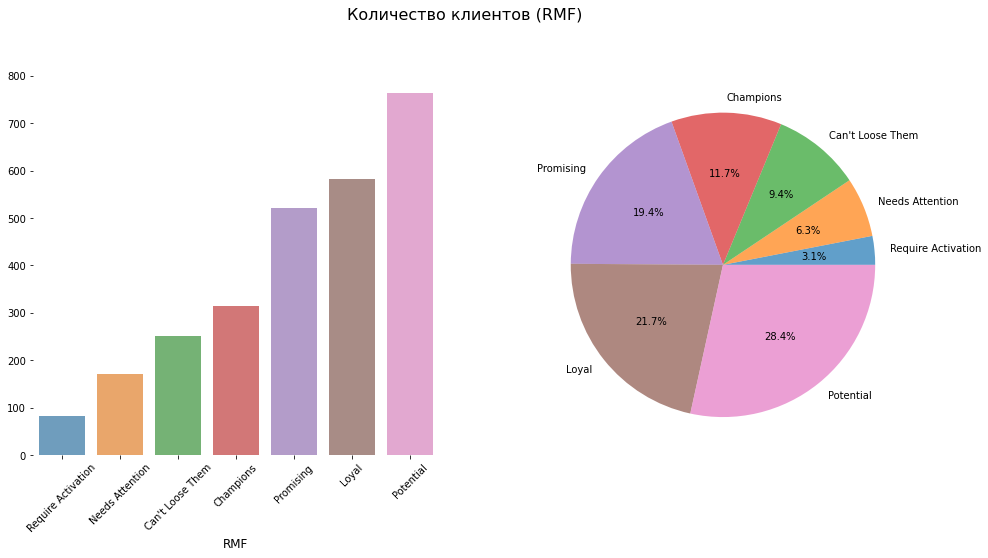

In [ ]:
univariate_multi_plot(df=df.query('segment != "no_rfm"'), x="segment", xlabel="RMF", rotation=45)

- мы выделили клиентов и теперь можем с ними работать более персонально

## 5.5 Сезонность

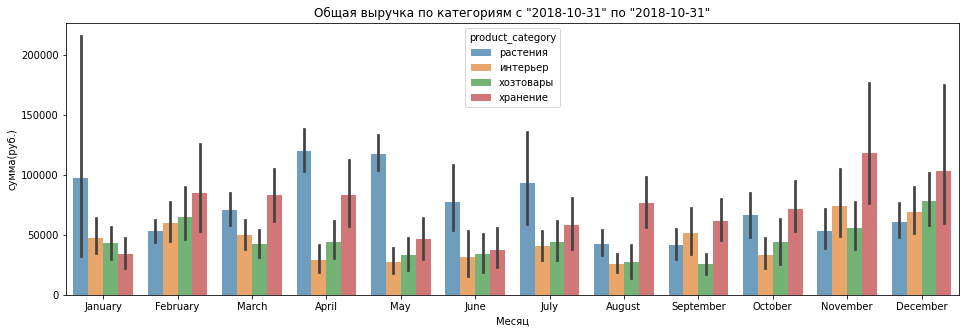

In [ ]:
plt.figure(figsize = (16, 5))
sns.barplot(data=df.query('date > @data_border'), x='month', y="revenue", hue="product_category", alpha=0.7, estimator=sum)
plt.title('Общая выручка по категориям с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='Месяц')
plt.ylabel(ylabel='сумма(руб.)')
plt.show()

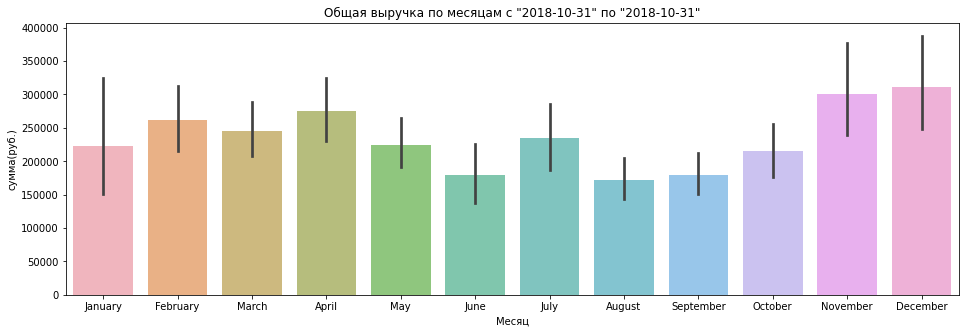

In [ ]:
plt.figure(figsize = (16, 5))
sns.barplot(data=df.query('date > @data_border'), x='month', y="revenue", alpha=0.7, estimator=sum)
plt.title('Общая выручка по месяцам с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='Месяц')
plt.ylabel(ylabel='сумма(руб.)')
plt.show()

In [ ]:
df.groupby('product_category')['revenue'].agg(['count', 'sum','mean']).reset_index().sort_values(by='sum', ascending=False)

,product_category,count,sum,mean
1,растения,2847,966216.00000,339.38040
3,хранение,510,911231.00000,1786.72745
2,хозтовары,500,625539.00000,1251.07800
0,интерьер,781,581428.00000,744.46607


- Категория растения преобладает в весенний период, но и в январе люди покупают растения. Лидер по выручке, имеет самый низкий средний чек. Имеет ярко выраженную сезонность.
- Хранение, вырчка за год почти такая же как у категории рестения, самый высокий чек. Имеет ярко выраженную сезонность.
- Хозтовары и интерьер почти равны по выручке, однако срений чек заметно отличается. Не имеет яркой сезонности.


## 5.6 ABC

- abc-xyz анализ, сделан по категориям, тоесть в каждой категории незваисимо от других категорий свое ранжирование товара.
- "A">"B">"C" где "А" товар который попадает в 80% от общей выручки категории, "В" в диапазоне 15% от общей выручки и "С" в 5% всей выручки категории. Вторая буква означает количество проданного товара от общего числа проданного товара в категории. 

In [ ]:
# сортировка по процентам (<80, 80-95, 95>)
def aabbcc(row):
  if row <= 0.8:
    return 'A'
  if row <= 0.95:
    return 'B'
  return 'C'

# сортировка по процентам (<15, 16-25, 25>)
def xyz(row):
  if row <= 0.15:
    return 'X'
  if row <= 0.25:
    return 'Y'
  return 'Z'

def get_abc(df, category):

  abc = (
    df.query('product_category == @category')
    .groupby('product')['revenue']
    .agg(['count', 'sum', 'mean', 'std'])
    .reset_index()
   )

  abc['revenue_pct'] = abc['sum'] / abc['sum'].sum()
  abc = abc.sort_values(by='revenue_pct', ascending=False)
  abc['cumsum'] = abc['revenue_pct'].cumsum()
  abc['abc_cumsum'] = abc['cumsum'].apply(aabbcc)

  abc_count = abc[['product', 'count']].sort_values(by='count', ascending=False)
  abc_count['count_pct'] = abc_count['count'] / abc_count['count'].sum()
  abc_count['cumcount'] = abc_count['count_pct'].cumsum()
  abc['abc_cumcount'] = abc_count['cumcount'].apply(aabbcc)

  abc['pct'] = abc['std'] / abc['mean']
  abc = abc.fillna(100)
  abc['xyz'] = abc['pct'].apply(xyz)
  
  abc['abc'] = abc['abc_cumsum'] + abc['abc_cumcount']
  
  return abc

In [ ]:
abc_xyz = pd.concat([get_abc(df, 'интерьер'), get_abc(df, 'растения'), get_abc(df, 'хозтовары'), get_abc(df, 'хранение')])
abc_xyz.head()

,product,count,sum,mean,std,revenue_pct,cumsum,abc_cumsum,abc_cumcount,pct,xyz,abc
217,муляж яблоко 9 см красное,5,17402.00000,3480.40000,4553.05077,0.02993,0.02993,A,A,1.30820,Z,AA
93,коврик придверный attribute nature кокосовый 6...,4,16888.00000,4222.00000,3046.97927,0.02905,0.05898,A,A,0.72169,Z,AA
309,скатерть 180 см wellness wtd180-лион*01 100% п...,1,8832.00000,8832.00000,100.00000,0.01519,0.07417,A,A,100.00000,Z,AA
322,скатерть рим 88% полиэфир 12% хлопок прямоугол...,1,7496.00000,7496.00000,100.00000,0.01289,0.08706,A,B,100.00000,Z,AB
83,"коврик для ванной прямоугольный, 4.5см. shaggy...",2,6297.00000,3148.50000,1484.21713,0.01083,0.09789,A,A,0.47140,Z,AA


In [ ]:
df = df.merge(abc_xyz[['product', 'abc', 'xyz']], how='left', on='product')

In [ ]:
df.head(1)

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month,product_category,last_purchase,rfm_score,segment,abc,xyz
0,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"сиденье в ванну раздвижное, белый, св5, ника",1,374.00000,374.00000,Sunday,October,интерьер,2018-10-28 22:00:00,0.00000,no_rfm,AA,Y


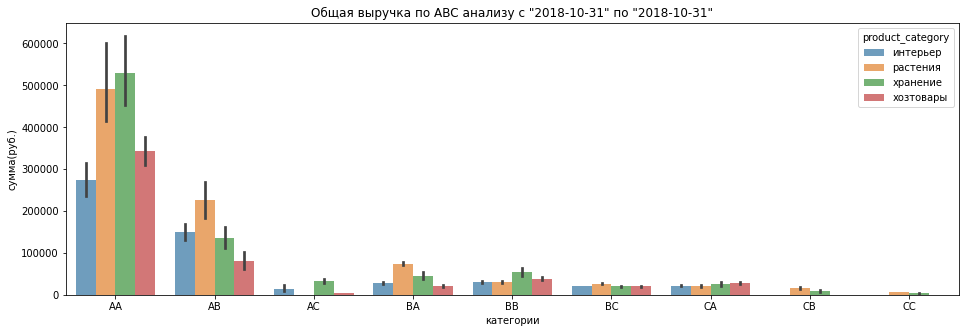

In [ ]:
plt.figure(figsize = (16, 5))
sns.barplot(data=df.query('date > @data_border').sort_values(by='abc'), x='abc', y="revenue", hue="product_category", alpha=0.7, estimator=sum)
plt.title('Общая выручка по ABC анализу с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='категории')
plt.ylabel(ylabel='сумма(руб.)')
plt.show()

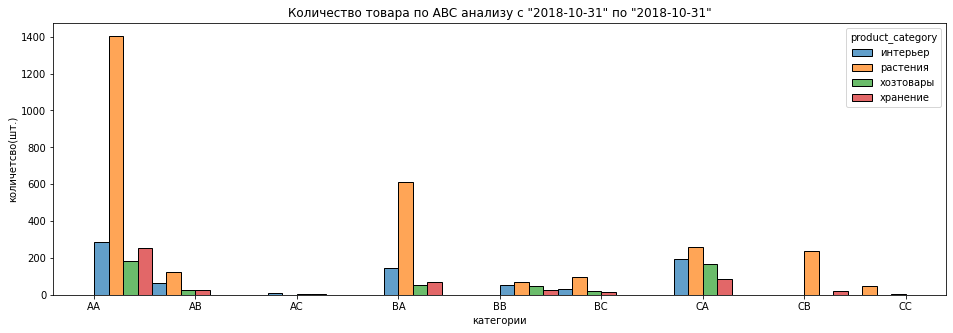

In [ ]:
plt.figure(figsize = (16, 5))
sns.histplot(df.sort_values(by='abc'), x='abc', hue="product_category", multiple="dodge",  discrete=False, alpha=0.7)
plt.title('Количество товара по ABC анализу с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='категории')
plt.ylabel(ylabel='количетсво(шт.)')
plt.show()

In [ ]:
df.groupby('abc')['revenue'].agg(['count', 'sum','mean'])

,count,sum,mean
abc,,,
AA,2127,1743569.00000,819.73155
AB,242,664791.00000,2747.07025
AC,21,57268.00000,2727.04762
BA,880,188324.00000,214.00455
BB,195,172544.00000,884.84103
BC,161,102091.00000,634.10559
CA,701,115420.00000,164.65050
CB,258,28167.00000,109.17442
CC,53,12240.00000,230.94340


- мы имеем слишком широкий ассортимент в группе АА, которая приности нам основну прибль. Следует стараться уменьшать ассортимент, при этом не уменьшая выручку. 
- группа АА имеет нибольшую выручку, при этом категория хранение и растения лидеры. Необходимо посмотреть на другие товары категорий и возможно отказаться от них и не тратить деньги на их закупку.

## 5.7 XYZ

- Стабильность спроса на товар "X"<"Y"<"Z" чем меньше значение, тем более стабильный спрос. "Х"<15% стабильный спрос, "Y"<25% нормальный спрос, 25%>"Z" низкий спрос.

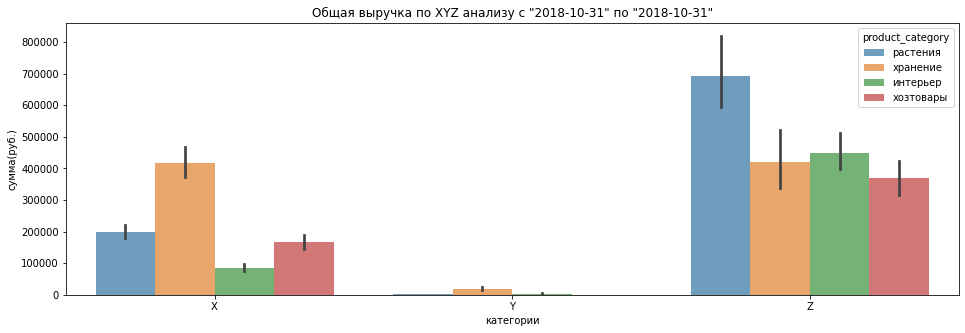

In [ ]:
plt.figure(figsize = (16, 5))
sns.barplot(data=df.query('date > @data_border').sort_values(by='xyz'), x='xyz', y="revenue", hue="product_category", alpha=0.7, estimator=sum)
plt.title('Общая выручка по XYZ анализу с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='категории')
plt.ylabel(ylabel='сумма(руб.)')
plt.show()

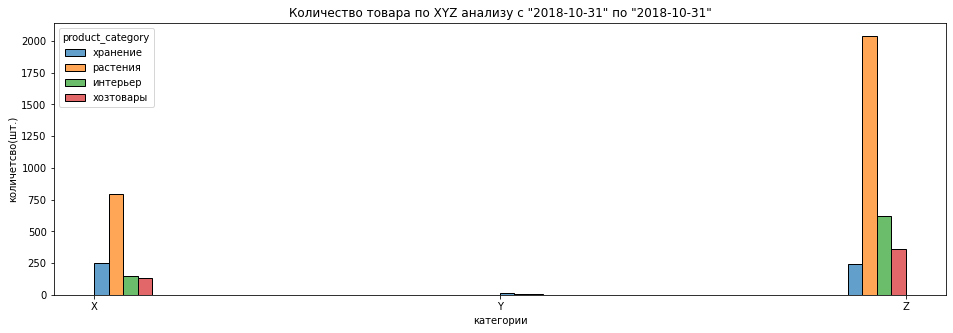

In [ ]:
plt.figure(figsize = (16, 5))
sns.histplot(df.sort_values(by='xyz'), x='xyz', hue="product_category", multiple="dodge",  discrete=False, alpha=0.7)
plt.title('Количество товара по XYZ анализу с "2018-10-31" по "2018-10-31"')
plt.xlabel(xlabel='категории')
plt.ylabel(ylabel='количетсво(шт.)')
plt.show()

- товары из категории Z следует закупать меньше или не закупать вовсе, при том категори Y необходимо расширить.

## 👩‍👩‍👧‍👧 5.8 Кластеризация

- создадим отдельную таблицу с цифровыми значениями
- введем доп переменную, будем считать что если клиент купил более 1 раза(так как абсолютное большинство клиентов покупает у нас 1 раз), то все хорошо и он "постоянный" == 1, если купил один раз будем считать что это отток == 0

In [ ]:
ml = df[['customer_id', 'product', 'quantity', 'revenue']]

In [ ]:
# соеденияем числовые значения abc_xyz
ml = (ml.merge(abc_xyz[['product', 'revenue_pct', 'cumsum', 'pct']], 
               how='left', 
               on='product'))

In [ ]:
t = df.groupby('customer_id')['order_id'].nunique().reset_index()

In [ ]:
t['return'] = t['order_id'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
t.head()

,customer_id,order_id,return
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,0
1,001cee7f-0b29-4716-b202-0042213ab038,1,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,0


In [ ]:
# добавляем переменную return
ml = ml.merge(t[['customer_id', 'return']], how='left', on='customer_id')

In [ ]:
ml = ml.drop(columns=['product'])

In [ ]:
ml = ml.rename(columns={'quantity':'quantity_order',
                   'revenue_pct':'abc_revenue',
                   'cumsum':'abc_count',
                   'pct':'xyz_pct'})

In [ ]:
ml.head()

,customer_id,quantity_order,revenue,abc_revenue,abc_count,xyz_pct,return
0,0b5ce2c7-acef-4a9a-b821-61a44ed05557,1,374.00000,0.00362,0.52772,0.21024,0
1,2f955596-4b13-432e-93f3-6433395aafe6,1,164.00000,0.00017,0.96716,100.00000,0
2,954172a5-634c-4a50-941d-9db6d15a7377,7,413.00000,0.00091,0.91040,1.15470,1
3,70d60304-4b3c-4f34-9430-1872ec6e6309,1,974.00000,0.00101,0.72595,100.00000,0
4,4ea06f66-0876-4dec-8d14-ea994ffe435f,3,66.00000,0.00083,0.92515,0.90339,0


In [ ]:
ml.corr().style.background_gradient(cmap='coolwarm')

,quantity_order,revenue,abc_revenue,abc_count,xyz_pct,return
quantity_order,1.000000,0.266442,0.081276,-0.092692,0.048983,-0.018548
revenue,0.266442,1.000000,0.370702,-0.325896,0.125405,-0.031583
abc_revenue,0.081276,0.370702,1.000000,-0.687028,-0.221707,0.015809
abc_count,-0.092692,-0.325896,-0.687028,1.000000,0.418121,-0.047191
xyz_pct,0.048983,0.125405,-0.221707,0.418121,1.000000,-0.100202
return,-0.018548,-0.031583,0.015809,-0.047191,-0.100202,1.000000


In [ ]:
# удаляем стоблцы где сильная кореляция
ml = ml.drop(columns=['abc_count'])

In [ ]:
ml = ml.drop(columns=['abc_revenue'])

In [ ]:
ml.corr().style.background_gradient(cmap='coolwarm')

,quantity_order,revenue,xyz_pct,return
quantity_order,1.000000,0.266442,0.048983,-0.018548
revenue,0.266442,1.000000,0.125405,-0.031583
xyz_pct,0.048983,0.125405,1.000000,-0.100202
return,-0.018548,-0.031583,-0.100202,1.000000


### 5.8.1 Стандартизируем данные

In [ ]:
# создаём объект класса scaler
scaler = StandardScaler()

In [ ]:
# обучаем нормализатор и преобразуем набор данных 
x_sc = scaler.fit_transform(ml.drop(columns=['customer_id'])) 

### 5.8.2 Дендограмма

In [ ]:
linked = linkage(x_sc, method = 'ward')

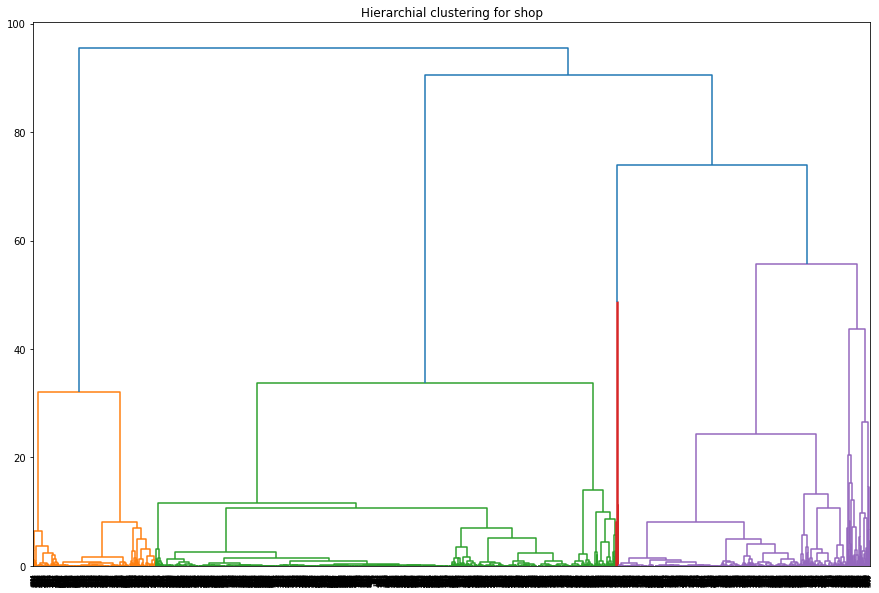

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for shop')
plt.show() 

### 5.8.3 Применяем алгоритм K-Means

In [ ]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters=4, random_state=42)

In [ ]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(x_sc)

In [ ]:
# метрикa силуэта 
silhouette_score(x_sc, labels) 

0.7052779215880555

### 5.8.4 Cредние значения признаков для кластеров

In [ ]:
ml['cluster'] = labels

In [ ]:
df = df.merge(ml[['customer_id', 'cluster']], how='left',on='customer_id')

In [ ]:
df.head(1)

,date,customer_id,order_id,product,quantity,price,revenue,dayweek,month,product_category,last_purchase,rfm_score,segment,abc,xyz,cluster
0,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"сиденье в ванну раздвижное, белый, св5, ника",1,374.00000,374.00000,Sunday,October,интерьер,2018-10-28 22:00:00,0.00000,no_rfm,AA,Y,1


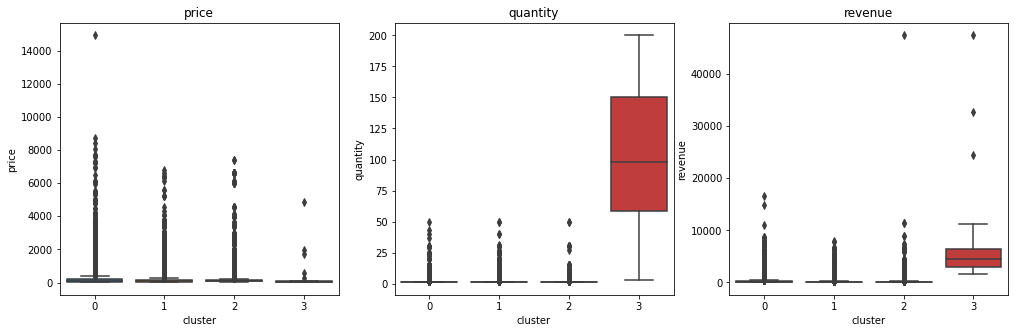

In [ ]:
# числовые
num_columns = ['revenue', 'price', 'quantity']

plt.figure(figsize=(17,5))
for i, column in enumerate(sorted(num_columns)):
  plt.subplot(1,3,i+1)
  sns.boxplot(x="cluster", y=column, data=df)
  plt.title(column)
plt.show()

In [ ]:
((ml.groupby('cluster').agg('mean').reset_index())
          .merge(ml.groupby('cluster')['customer_id']
                 .count()
                 .reset_index(), how='left', on='cluster')
          .T
 )

,0,1,2,3
cluster,0.00000,1.00000,2.00000,3.00000
quantity_order,2.19505,1.87616,2.02286,94.00000
revenue,909.46137,519.72368,489.89857,8867.00000
xyz_pct,100.00000,0.36137,21.43193,62.37716
return,0.00000,0.00000,1.00000,0.04762
customer_id,1333.00000,2584.00000,700.00000,21.00000


- 2 кластер имеет 100% вероятность повторной покупки, среднее количество товара 2, средний чек 489 руб, с товаром из категории XYZ со средним значением 21% (средний спрос на товар)
- 3 кластер имеет 4% вероятность вернуться, средний чек 8800, наибольшее количество товара 94 в среднем, при этом XYZ 62% (плохой спрос на товар), но у него очень маленькое количество клиентов.

# 👩🏼‍🔬 6. Проверка гипотез c помощью t-test

## 6.1 Средняя выручка категории "хранение" и "хозтовар" различаются

### 6.1.1 Распределние на qqplot



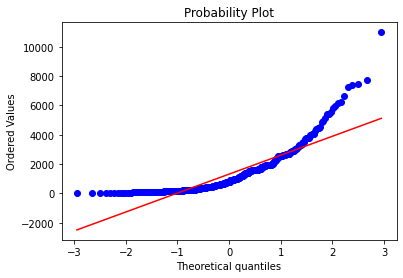

In [ ]:
st.probplot(df.query('product_category == "хозтовары"').groupby('customer_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('product_category == "хозтовары"')['revenue'].count()

1252

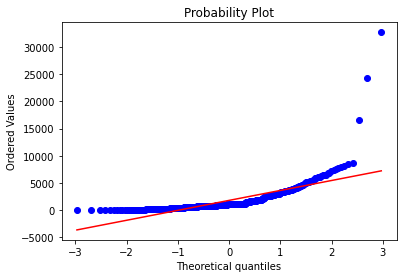

In [ ]:
st.probplot(df.query('product_category == "хранение"').groupby('customer_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('product_category == "хранение"')['revenue'].count()

845

- Распредление не нормально, но для критерия Стюдента при большой выборке (более 30 значений) это не обязательно.
- Ссылка на статью про **необязательное** нормальное распредление для t-критерий (критерий Стьюдента):

[я ссылка](https://koch-kir.medium.com/%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F-%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D0%BC%D0%B0%D0%BD%D0%B0-%D0%B8%D0%BB%D0%B8-%D1%82%D1%80%D0%B5%D0%B1%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8E-%D0%B2-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%85-55139a5558d)

### 6.1.2 Формулируем гипотезы

**H0:** средняя выручка клиентов категории "хранение" и "хозтовар" **равны**


**H1:** средняя выручка клиентов категории "хранение" и "хозтовар"  **различаются** 

### 6.1.3 Проводим т-тест

In [ ]:
# t-test - Гипотеза о равенстве средних двух генеральных совокупностей
alpha = 0.01

results = st.ttest_ind(
    df.query('product_category == "хозтовары"')['revenue'],
    df.query('product_category == "хранение"')['revenue'],
     equal_var=False)

print('p-значение:', np.round(results.pvalue, decimals=5))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


- Нулевая гипотеза о равенстве средних выручек категорий, **не подтвердилась.**

## 6.2 Средняя выручка в мае отличается от апреля

### 6.2.1 Распределние на qqplot

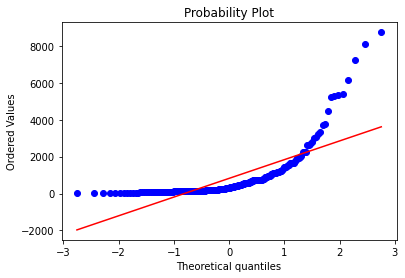

In [ ]:
st.probplot(df.query('month == "April"').groupby('customer_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('month == "April"')['revenue'].count()

9321

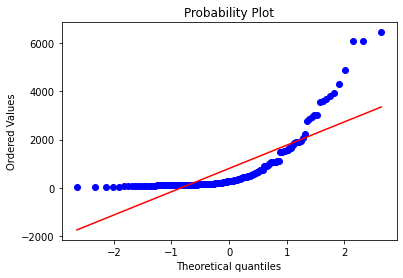

In [ ]:
st.probplot(df.query('month == "May"').groupby('customer_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('month == "May"')['revenue'].count()

10812

### 6.2.2 Формулируем гипотезы

**H0:** средняя выручка покупателей в мае и апреле **равны**

**H1:** средняя выручка покупателей в мае и апреле **различаются** 

### 6.2.3 Проводим т-тест

In [ ]:
# t-test - Гипотеза о равенстве средних двух генеральных совокупностей
alpha = 0.01

results = st.ttest_ind(
    df.query('month == "April"')['revenue'],
    df.query('month == "May"')['revenue'],
     equal_var=False)

print('p-значение:', np.round(results.pvalue, decimals=5))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.15897
Не получилось отвергнуть нулевую гипотезу


- Нулевая гипотеза о равенстве средних выручек покупателей в мае и апреле, **подтвердилась.**

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,34828.00000,24919.04697,21411.17620,12624.00000,14688.00000,14764.00000,14892.00000,73164.00000
quantity,34828.00000,1.49945,3.34692,1.00000,1.00000,1.00000,1.00000,200.00000
price,34828.00000,188.70550,456.02718,9.00000,59.00000,116.00000,150.00000,14917.00000
revenue,34828.00000,239.40367,687.03657,9.00000,78.00000,120.00000,188.00000,47385.00000
rfm_score,34828.00000,5.11333,3.12222,0.00000,4.00000,6.00000,7.00000,12.00000
cluster,34828.00000,1.00620,0.68632,0.00000,1.00000,1.00000,1.00000,3.00000


# 📝 7. Выводы

- Период исследования данных 1 год и 31 день, с 2018 октября по 2019 октября.В среднем в нашем магазине покупают 1.5 шт товара, при стоимости товара 188 руб, на общую сумму 239 руб. **75% покупателей тратят в нашем магазине не более 188 рублей**. В день к нам приходят 6 покупателей, в неделю 43, а в год 189 покупателей в среднем.
 
- Больше всего покупателей приходят в апреле и мае, это связано с сезоном, так как в нашем магазине широкий ассортимент категории растения. В Январе самый маленький поток покупателей. В наш магазин ходят в рабочие дни, особенно в понедельник, в выходные и пятницу ходят меньше. Похоже что это связано с тем что наши клиенты это садоводы, и выходные они проводят на своих участках.
 
- Попытка выделить оптовых покупателей из таблицы, привела к тому мы получили некоторый список клиентов (всего их 7), которые покупают на большие суммы. Все они вынесены в отдельную таблицу, с ними нужно проработать индивидуально и предложить особые условия.
 
> Товар разделен на 4 категории: растения/интерьер/хозтовары/хранение
- **Категория растения** преобладает в весенний период. Категория лидер по выручке, но имеет самый низкий средний чек. Имеет ярко выраженную сезонность.
- **Хранение**, выручка за год почти такая же как у категории растения, самый высокий средний чек. Имеет ярко выраженную сезонность.
- **Хозтовары и интерьер** почти равны по выручке, однако средний чек заметно отличается. Не имеет яркой сезонности.
 
- **RFM анализ** выявил главное в исследовании:
 **в наш магазин приходят покупают один раз и не возвращаются**
==== 
- Это повод задуматься, прежде чем что то делать с клиентами и пытаться их вернуть, нужно посмотреть внутри магазина там явно что то не так. Например в апреле и мае все хорошо потому что сезон посадки, нужно придумывать что делать в остальные месяцы.
 
- **ABC анализ** выявил, что мы имеем слишком широкий ассортимент в группе АА(где категория хранение и растения лидеры), которая приносит нам основную прибыль. Следует уменьшить ассортимент.
 
- **XYZ анализ** показал, товары из категории Z следует закупать меньше или не покупать вовсе, при том категори Y необходимо расширить.
 
- Кластеризация выявила что 2 й кластер имеет 100% вероятность повторной покупки, среднее количество товара 2, средний чек 489 руб, с товаром из категории XYZ со средним значением 21% (средний спрос на товар), следует более детально изучать 2 й кластер.
 
> Гипотеза о равенстве средних выручек категорий "хранение" и "хозтовар", **не подтвердилась.**
 
> Гипотеза о равенстве средних выручек покупателей в мае и апреле, **подтвердилась.**


# 💬 Заключение

## Что сделано:
- Получены данные магазина по продаже хозяйственных товаров и рассады. Файл содержит 5 столбцов, 6737 строк, пропуски отсутствуют. К таблице была добавлена колонка с расчетов выручки revenue. Явных дубликатов не обнаружено, однако при проверке на дубликаты без колонки date, видим что один и тот же покупатель у него одинаковый номер заказа, стоимость, количество и выручка также совпадают. Разное только время. Такие повторы были удалены. 
 
- Поиск дубликатов среди '**customer_id**' и '**order_id**', выявил 29 дубликатов. Выяснилось что это ошибка, так как один заказ содержал одинаковые поля, кроме поля customer_id. Получается что заказ один, а клиентов много, самый яркий пример где 4 разных клиента я вывел ниже. Принято решение удалить.
 
- В таблице были клиенты, 7 человек, которые сделали большое количество заказов, на внушительную сумму по отношению к другим пользователям. Их количество не превысило 1% от общего числа, была создана отдельная таблица **opt_df**.
 
- Требовалось создать категории товара для дальнейшего анализа. Чтобы сделать категории товаров, взяли первое слово из колонки product, создали цикл где нам будет выводится слово, мы будем вручную для него определять категорию. Мы получили 7 категорий, которые сильно отличаются друг от друга по количеству позиций товара, а также выручкой. Принято решение объединить категории чтобы осталось 4, так как это учебный проект. В жизни я бы поделил их на еще большее количество категорий, для более детального изучения.
 
- Для RFM анализа была сделана таблица profiles по id, дате первого заказа, выручке, сколько дней прошло с последней покупки, количество заказов.
 
- ABC и XYZ анализ, сделан по категориям, то есть в каждой категории независимо от других категорий свое ранжирование товара. "A">"B">"C" где "А" товар который попадает в 80% от общей выручки категории, "В" в диапазоне 15% от общей выручки и "С" в 5% всей выручки категории. Вторая буква означает количество проданного товара от общего числа проданного товара в категории. Стабильность спроса на товар "X"<"Y"<"Z" чем меньше значение, тем более стабильный спрос. "Х"<15% стабильный спрос, "Y"<25% нормальный спрос, 25%>"Z" низкий спрос.
 
- Для определения кластеров создана отдельная таблица ml с цифровыми значениями. Введена доп переменная, если клиент купил более 1 раза(так как абсолютное большинство клиентов покупает у нас 1 раз), то все хорошо и он "постоянный" == 1, если купил один раз будем считать что это отток == 0. На основании дендрограммы выделено 4 кластера. 
 
- Проверены две гипотезы, распределение в группах не нормально, доказано на qqplot. Для проведения теста выбран критерий Стьюдента.







In [ ]:
df.to_csv('data_diplom.csv')